In [9]:
import requests
import time
import PySpin
import pyrealsense2 as rs
import sys
sys.path.append('../')
import capture_thermal_image as thermalcapture

ModuleNotFoundError: No module named 'PySpin'

In [8]:
!pip install PySpin --no-deps

In [ ]:
print(requests.get("http://localhost:8010/RestPLCService/getint?address=4020").json()["Value"])

In [ ]:
requests.get("http://localhost:8010/RestPLCService/setint?address=4010&value=%d" % 1209)

In [ ]:
requests.get("http://localhost:8010/RestPLCService/setint?address=4010&value=%d" % 1510)

In [ ]:
import time
import pyrealsense2 as rs
import numpy as np
import cv2
from datetime import datetime
import os
import json

In [ ]:
"""
Author: spsaswat & Zishuang Xing

Description:
This script demonstrates the process of acquiring images using the Intel RealSense camera via the pyrealsense2 library. 
The script showcases essential steps including starting and stopping the camera pipeline, capturing a specified number 
of images with a delay between each capture, saving camera intrinsics, and handling file paths dynamically based on the 
execution time. This utility is particularly useful in computer vision applications that require synchronized color and 
depth data from RealSense cameras.

"""

# Initialize the global variable
current_position = 0.0
all_imgs = []

# serial_number = 'f1230450' #L515
# serial_number = '017322071325' #D435
serial_number = '128422272123'  #D405

#Set the basic path for data storage
save_fold_p = './data/test_plant_'

now = datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")
save_fold_p = save_fold_p + dt_string + '/'
#If it does not exist, create a save directory
os.makedirs(save_fold_p, exist_ok=True) 

def start_pipeline():
    # Start streaming
    pipeline.start(config)
    # Get the depth sensor and set the visual preset


def stop_pipeline():
    # Stop streaming
    pipeline.stop()
    

def save_intrinsics():
    # Get the intrinsics
    profile = pipeline.get_active_profile()
    
    depth_sensor = profile.get_device().first_depth_sensor()
    depth_scale = depth_sensor.get_depth_scale()
    depth_sensor.set_option(rs.option.visual_preset, 4)  # 4 High accuracy for D435 and D405 # 5 L515 short range 

    # depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.color))  #change it back if it doesnot work
    depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.depth))
    depth_intrinsics = depth_profile.get_intrinsics()

    # Save the intrinsics in the required format
    intrinsics_dict = {
        "K": [
            [depth_intrinsics.fx, 0, depth_intrinsics.ppx],
            [0, depth_intrinsics.fy, depth_intrinsics.ppy],
            [0, 0, 1]
        ],
        # Assuming that the distortion model is "Brown-Conrady",
        # you can get the distortion parameters like this.
        "dist": depth_intrinsics.coeffs,
        "height": depth_intrinsics.height,
        "width": depth_intrinsics.width
    }

    # Write the data to a .txt file
    with open(save_fold_p+'kd_intrinsics.txt', 'w') as outfile:
        json.dump(intrinsics_dict, outfile, indent=4)
        
        
    #remove below code after intrinsics finalized
    depth_profile = rs.video_stream_profile(profile.get_stream(rs.stream.color)) 
    depth_intrinsics = depth_profile.get_intrinsics()

    # Save the intrinsics in the required format
    intrinsics_dict = {
        "K": [
            [depth_intrinsics.fx, 0, depth_intrinsics.ppx],
            [0, depth_intrinsics.fy, depth_intrinsics.ppy],
            [0, 0, 1]
        ],
        # Assuming that the distortion model is "Brown-Conrady",
        # you can get the distortion parameters like this.
        "dist": depth_intrinsics.coeffs,
        "height": depth_intrinsics.height,
        "width": depth_intrinsics.width
    }

    # Write the data to a .txt file
    with open(save_fold_p+'kdc_intrinsics.txt', 'w') as outfile:
        json.dump(intrinsics_dict, outfile, indent=4)


def capture_images(pipeline, position_str, total_images=1, delay=0):
    # Capture a specified number of images, pausing for a set time between captures
    for i in range(total_images):
        frames = pipeline.wait_for_frames()
        # Align depth frames to color frames to ensure depth and color data match
        aligned_frames = align.process(frames)
        depth_frame = aligned_frames.get_depth_frame()
        color_frame = aligned_frames.get_color_frame()
        
        # Convert frame data to numpy arrays for processing and saving with OpenCV
        depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())
        
        # # Save color and depth images with filenames "rgb_x.png" and "depth_x.png", where x is the sequence number
        # position_str = f"position_str" 
        
        cv2.imwrite(os.path.join(save_fold_p, f'rgb_{position_str}.png'), color_image)
        cv2.imwrite(os.path.join(save_fold_p, f'depth_{position_str}.png'), depth_image)

        time.sleep(delay) # Wait for a specified time (in seconds) between captures

# Configure the RealSense camera
pipeline = rs.pipeline()
config = rs.config()
config.enable_device(serial_number)
# Configure the stream parameters according to device capabilities and needs
config.enable_stream(rs.stream.color, 1280, 720, rs.format.bgr8, 30)  
config.enable_stream(rs.stream.depth, 1280, 720, rs.format.z16, 30) 
align = rs.align(rs.stream.color) #Align depth frames to color frames

# Sequentially execute starting the pipeline, saving intrinsics, capturing images, and stopping the pipeline
start_pipeline()
save_intrinsics()

In [ ]:
tt = requests.get("http://localhost:8010/RestPLCService/getint?address=4020").json()["Value"]
print(str(tt))

In [ ]:
li_th_pos = [1340, 1055, 740, 435, 1510]
if requests.get("http://localhost:8010/RestPLCService/getint?address=4020").json()["Value"] != 1510:
    requests.get("http://localhost:8010/RestPLCService/setint?address=4010&value=%d" % 1510)
    time.sleep(10)
    print("The gantry's position is:", requests.get("http://localhost:8010/RestPLCService/getint?address=4020").json()["Value"])
    # call rgbd and thermal capture
    
for pos in li_th_pos:
    requests.get("http://localhost:8010/RestPLCService/setint?address=4010&value=%d" % pos)
    position_f = requests.get("http://localhost:8010/RestPLCService/getint?address=4020").json()["Value"]
    print("The gantry's position is:", position_f)
    time.sleep(10)
    # call rgbd and thermal capture
    capture_images(pipeline, position_f, 1, 0)

    # main start
    thermalcapture.NUM_IMAGES = 1
    thermalcapture.pos = position_f
    thermalcapture.main()
    # main end
    time.sleep(5)
   
    
stop_pipeline()

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Load the original mono16 image
img = cv2.imread("../SensorCommunication/Acquisition/20240815-155900_tiff/20240815-155900/Acquisition-1509.tiff", -1)

# Normalize the data
percentile_95 = np.percentile(img, 95)
normalized_data = np.clip(img, None, percentile_95)

min_val = np.min(normalized_data)
max_val = np.max(normalized_data)
normalized_data = (normalized_data - min_val) / (max_val - min_val)

# Apply a colormap. You can try different colormaps: 'jet', 'plasma', 'inferno', etc.
colored_image = plt.cm.jet(normalized_data)  # JET colormap is generally used for thermal images

# Convert to 8-bit RGB
colored_image_16bit = (colored_image[:, :, :3] * 65535).astype('uint16')

# Save the 16-bit image using OpenCV
cv2.imwrite("../SensorCommunication/Acquisition/20240815-155900_tiff/20240815-155900/Acquisition-1509-colored.tiff", colored_image_16bit)

print("16-bit color image saved successfully.")

16-bit color image saved successfully.


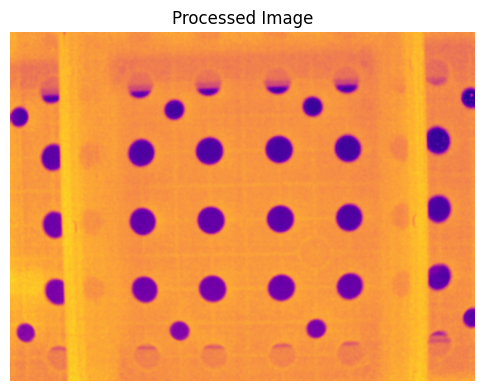

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def minmax_normalize(image):
    # Flatten the image and count pixel frequencies
    flat_image = image.flatten()
    pixel_counts = Counter(flat_image)
    
    # Find the pixel value with the least frequency
    min_pixel_value = min(pixel_counts, key=pixel_counts.get)
    
    # Normalize based on min_pixel_value and max
    norm_image = (image - min_pixel_value) / (np.max(image) - min_pixel_value)
    
    # Clip to range [0, 1]
    norm_image = np.clip(norm_image, 0, 1)
    
    return norm_image

def process_image(image_path):
    # Load the image in 16-bit
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    # Min-max normalization
    normalized_image = minmax_normalize(image)
    
    # Apply Gaussian blur
    blurred_image = cv2.GaussianBlur(normalized_image, (5, 5), 0)
    
    return blurred_image

def plot_image(image, title):
    plt.imshow(image, cmap='plasma', vmin=0, vmax=1)
    # plt.imshow(image, cmap="gray", vmin=0, vmax=1)
    plt.title(title)
    plt.axis('off')

# Path to the image
image_path = "../SensorCommunication/Acquisition/calib_data_2/calib_data_2/20240822-125442/Acquisition-1054.tiff"

# Process the image
processed_image = process_image(image_path)

# Plot the processed image
plt.figure(figsize=(6, 6))
plot_image(processed_image, 'Processed Image')
plt.show()

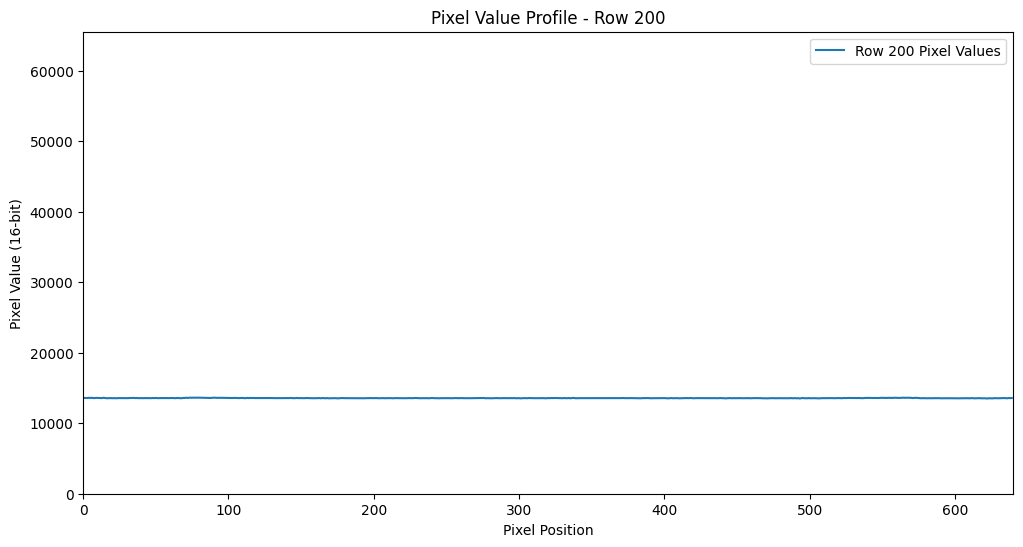

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_pixel_line_profile(image, row=0):
    # Extract the pixel values along the specified row
    pixel_values = image[row, :]

    # Plot the pixel values
    plt.figure(figsize=(12, 6))
    plt.plot(pixel_values, label=f'Row {row} Pixel Values')
    plt.title(f'Pixel Value Profile - Row {row}')
    plt.xlabel('Pixel Position')
    plt.ylabel('Pixel Value (16-bit)')
    plt.xlim([0, image.shape[1]])
    plt.ylim([0, 65535])
    plt.legend()
    plt.show()

# Load the original image
image_path = "../SensorCommunication/Acquisition/calib_data_2/calib_data_2/20240822-125442/Acquisition-1054.tiff"
original_image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

# Plot the pixel value profile for a specific row
plot_pixel_line_profile(original_image, row=200)